# Regresja liniowa, Ridge i Lasso

## a) Przykład równania regresji i predykcji

Rozważmy regresję liniową z dwiema zmiennymi objaśniającymi:

$$
\hat y = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

Przykładowo (czysto ilustracyjnie), jeśli zmienne są funkcjami cosinus:

$$
\hat y = \beta_0 + \beta_1 \cos(x_1) + \beta_2 \cos(x_2)
$$

Dla przykładowych współczynników:
- $$\beta_0 = 1.0$$
- $$\beta_1 = 0.5$$
- $$\beta_2 = -0.3$$

oraz danych:
- $$x_1 = 0$$
- $$x_2 = \pi / 2$$

predykcja $$\hat y$$ jest liczona przez bezpośrednie podstawienie do wzoru.

---

## b) Funkcja straty – wersja podstawowa

W regresji liniowej chcemy, aby predykcja $$\hat y$$ była jak najbliżej wartości rzeczywistej $$y$$.

Najprostsza intuicyjna strata to różnica:

$$
(y - \hat y)
$$

W praktyce różnicę tę podnosi się do kwadratu i sumuje po wszystkich obserwacjach.

Ważne jest, aby pamiętać, że:

$$
\hat y = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

---

## c) Funkcja straty Ridge (L2)

W regresji Ridge do klasycznej straty dodajemy karę za duże wartości współczynników:

$$
RSS_{L2} =
\sum_{i=1}^{n} (y_i - \hat y_i)^2
+
\lambda \sum_{j=1}^{p} \beta_j^2
$$

Kara L2 powoduje, że:
- duże współczynniki są silnie tłumione,
- bardzo małe współczynniki (dużo mniejsze od 1) są karane słabo.

---

## d) Funkcja straty Lasso (L1)

W regresji Lasso stosuje się inną postać kary:

$$
RSS_{L1} =
\sum_{i=1}^{n} (y_i - \hat y_i)^2
+
\lambda \sum_{j=1}^{p} |\beta_j|
$$

Kara L1 (wartość bezwzględna):
- silnie karze nawet bardzo małe w

**W skrócie:** Lasso sprzyja selekcji zmiennych, a Ridge stabilizacji współczynników.


**W skrócie:** Lasso sprzyja selekcji zmiennych, a Ridge stabilizacji współczynników.
**W skrócie:**  
Lasso sprzyja selekcji zmiennych, a Ridge stabilizacji współczynników.


## e) Porównanie Ridge i Lasso – intuicja

- **Lasso** mocno karze małe współczynniki kierunkowe, co sprzyja ich wyzerowaniu (selekcja zmiennych).
- **Ridge** jest łagodny dla bardzo małych współczynników (≪ 1), ale coraz silniej karze współczynniki duże.
- Różnica ta wynika bezpośrednio z postaci kary: $$\beta^2$$ (Ridge) vs $$|\beta|$$ (Lasso).

**W skrócie:** Lasso sprzyja selekcji zmiennych, a Ridge stabilizacji współczynników.

In [26]:
from sklearn.metrics import mean_absolute_error

In [1]:
# =========================
# Core libraries
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization (optional but common)
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Scikit-learn: data & utilities
# =========================
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# =========================
# Scikit-learn: regression models
# =========================
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# =========================

# =========================


# =========================
# Scikit-learn: metrics
# =========================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# Load California Housing dataset
# =========================
california = fetch_california_housing(as_frame=True)

X = california.data
y = california.target

df = X.copy()
df["target"] = y

# Dataset description (string)
dataset_description = california.DESCR

# Quick sanity check
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [2]:
print(dataset_description)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
for c in df.columns :
    print(c, '\n' * 2, df[c].sample(n = 10), '\n')

MedInc 

 12000    7.5408
14895    2.1441
9720     4.6125
18575    2.8348
13681    4.6445
12569    2.4618
15672    7.9761
5481     3.1607
11013    4.2750
17956    5.1506
Name: MedInc, dtype: float64 

HouseAge 

 70       26.0
7655     28.0
16859    41.0
1953     28.0
18837    50.0
12315    26.0
337      46.0
17537    47.0
4841     38.0
4587     37.0
Name: HouseAge, dtype: float64 

AveRooms 

 18883    4.763374
1147     7.028436
16020    7.379464
12917    6.725124
19807    9.789474
19124    6.072356
5849     3.525974
11882    4.240000
16035    5.486364
2011     5.386076
Name: AveRooms, dtype: float64 

AveBedrms 

 3706     1.080670
5760     0.980707
19483    1.035294
17989    1.050388
736      1.024691
2564     0.996564
19465    1.236765
13833    1.043716
4646     1.132428
2287     1.045608
Name: AveBedrms, dtype: float64 

Population 

 10489     983.0
116      2558.0
12656    1596.0
13108    2916.0
2444      737.0
3184     1255.0
6384     1236.0
3589     1207.0
14337     873.0
1167

In [7]:
statystyki_opisowe = df.describe().round(2)
statystyki_opisowe

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


In [8]:
statystyki_opisowe.loc[['mean', '50%', 'min', 'max'], : ]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


In [9]:
df[df.duplicated()]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target


In [14]:
df.target.sum()

42695.04061

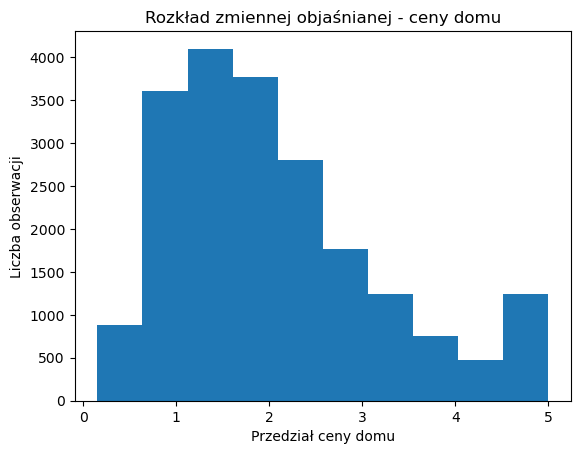

In [21]:
df.target.plot.hist()
plt.title('Rozkład zmiennej objaśnianej - ceny domu')
plt.ylabel('Liczba obserwacji')
plt.xlabel('Przedział ceny domu')
plt.show()

In [25]:
naiwna_predykcja_srednia = df.target.mean()
naiwna_predykcja_srednia

2.0685581690891843

In [10]:
# =========================
# Train-test split (default setup)
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
y_train.sum() + y_test.sum()

42695.04061

In [17]:
trainset.MedHouseVal.sum() + testset.MedHouseVal.sum()

42695.04061

In [11]:
X_train.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16


In [12]:
trainset = pd.concat( [X_train, y_train], axis = 1)
testset = pd.concat( [X_test, y_test], axis = 1)

trainset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965
